img.shape:  (256, 256, 3)
通道數:  3
通道 1 的唯一值: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 2

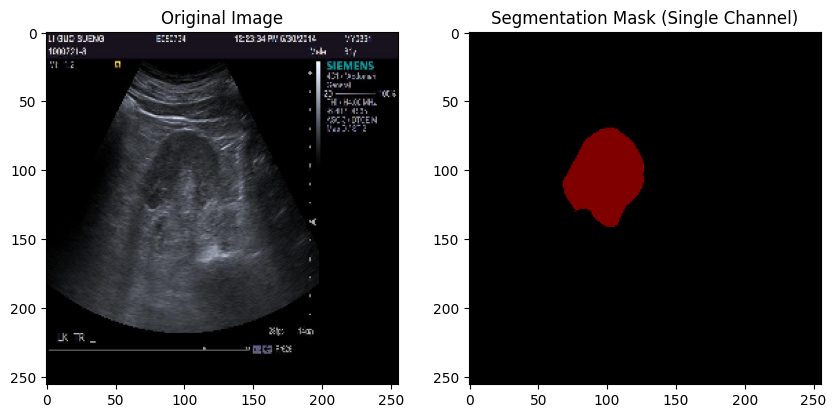

In [10]:
import os
import cv2
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from skimage.io import imshow
import matplotlib.pyplot as plt

size = 256
img_path = '/tf/PatchCL-MedSeg/0_data_dataset_voc_950_kidney/JPEGImages/1000221_8_DATE20140630_STD02_SER01_IMG013.jpg'
mask_path = '/tf/PatchCL-MedSeg/0_data_dataset_voc_950_kidney/SegmentationClassPNG/1000221_8_DATE20140630_STD02_SER01_IMG013.png'

img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (size, size), interpolation=cv2.INTER_NEAREST)
print('img.shape: ', img.shape)
img_num_channels = img.shape[-1]
print('通道數: ', img_num_channels)

for channel_idx in range(img_num_channels):
    channel_img = img[:, :, channel_idx]
    unique_values = np.unique(channel_img)
    print(f"通道 {channel_idx+1} 的唯一值:", unique_values)

print('===========================================================')
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
mask = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)
print('mask.shape: ', mask.shape)
mask_num_channels = mask.shape[-1]
print('通道數: ', mask_num_channels)

for channel_idx in range(mask_num_channels):
    channel_mask = mask[:, :, channel_idx]
    unique_values = np.unique(channel_mask)
    print(f"通道 {channel_idx+1} 的唯一值:", unique_values)
    
# 顯示原圖和紅色通道的影像
plt.figure(figsize=(10, 5))
# 左邊顯示原圖
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

# 右邊顯示紅色通道的影像
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title("Segmentation Mask (Single Channel)")

plt.show()

img_.shape:  (256, 256, 3)
mask_.shape:  (256, 256)
{0: 62651, 128: 2885}


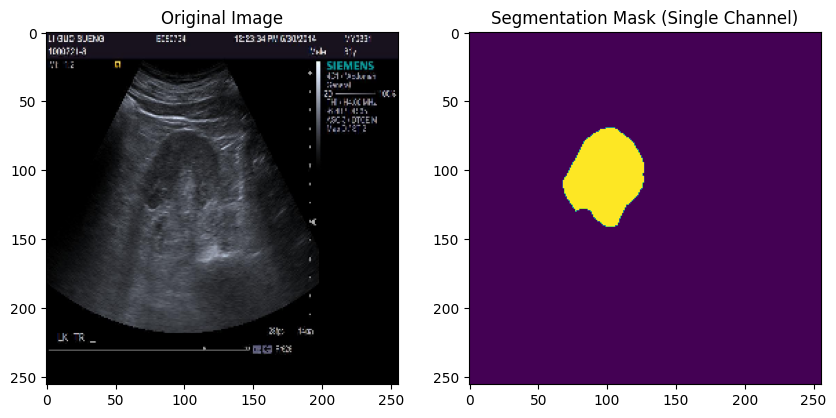

In [14]:
img_ = img
mask_ = mask[:, :, 0] # mask.shape:  (256, 256, 3) to (256, 256)
print('img_.shape: ', img_.shape) # output: img_.shape:  (256, 256, 3)
print('mask_.shape: ', mask_.shape) # output: mask.shape:  (256, 256)

img_unique, img_counts = np.unique(img_, return_counts=True)
img_pixel_counts = dict(zip(img_unique, img_counts))
# print(img_pixel_counts)

mask_unique, mask_counts = np.unique(mask_, return_counts=True)
mask_pixel_counts = dict(zip(mask_unique, mask_counts))
print(mask_pixel_counts)

# 顯示原圖和紅色通道的影像
plt.figure(figsize=(10, 5))
# 左邊顯示原圖
plt.subplot(1, 2, 1)
plt.imshow(img_)
plt.title("Original Image")

# 右邊顯示紅色通道的影像
plt.subplot(1, 2, 2)
plt.imshow(mask_)
plt.title("Segmentation Mask (Single Channel)")

plt.show()

In [1]:
base_path = '/tf/PatchCL-MedSeg'

img_size = 256
supervised_epochs = 100
patch_size = 64
contrastive_batch_size = 256
batch_size = 16
classes = 2
data_dir = base_path + '/0_data_dataset_voc_950_kidney/'
output_dir = base_path + '/dataset/splits/kidney/1-3/'

# Loss 紀錄
supervised_loss_path = base_path + '/supervised pre training_loss.csv'
SSL_loss_path = base_path + '/SSL_loss.csv'

best_contrast_supervised_model = base_path + '/best_contrast_supervised.pth'

In [2]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import math
import time
import sys
import os
import numpy as np
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset, random_split, Dataset
import matplotlib.pyplot as plt

sys.path.append(base_path)
from utils.stochastic_approx import StochasticApprox
from utils.model import Network
# from dataloaders.dataset_kidney_binary_mask import BaseDatasets  
from dataloaders.dataset_kidney import BaseDatasets  
from utils.queues import Embedding_Queues
from utils.CELOSS import CE_loss
from utils.patch_utils import _get_patches
from utils.aug_utils import batch_augment
from utils.get_embds import get_embeddings
from utils.const_reg import consistency_cost
from utils.plg_loss import PCGJCL
from utils.torch_poly_lr_decay import PolynomialLRDecay
from utils.loss_file import save_loss, check_loss_file

In [3]:
dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dev)

stochastic_approx = StochasticApprox(classes,0.5,0.8)
embd_queues = Embedding_Queues(classes)
cross_entropy_loss=CE_loss()
metrics=[smp.utils.metrics.IoU(threshold=0.5)]

cuda:0


In [4]:
with open(os.path.join(output_dir, "labeled.txt"), 'r') as file:
    labeled_files = [line.strip().split(' ') for line in file.readlines()]

with open(os.path.join(output_dir, "unlabeled.txt"), 'r') as file:
    unlabeled_files = [line.strip() for line in file.readlines()]

In [5]:
VOC_CLASSES = ["_background_", "kidney"]
VOC_COLORMAP = [[0, 0, 0], [120, 0, 0]]

In [6]:
# 假設你已經定義了 labeled_files, unlabeled_files, data_dir, transform, VOC_COLORMAP 和 batch_size
labeled_dataset = BaseDatasets(
    file_list=labeled_files, 
    img_folder=data_dir, 
    msk_folder=data_dir, 
    size=img_size
)

unlabeled_dataset = BaseDatasets(
    file_list=unlabeled_files, 
    img_folder=data_dir, 
    size=img_size,
)

labeled_dataloader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)

print('===========================================================')
print('number of labeled_dataset: ', len(labeled_dataset))
print('number of unlabeled_dataset: ', len(unlabeled_dataset))
print('===========================================================')
print('labeled_dataloader shape')
for imgs, masks in labeled_dataloader:
    print('img shape: ', imgs.shape)
    print('mask shape: ', masks.shape)
    break
print('===========================================================')

print('unlabeled_dataloader shape')
for imgs in unlabeled_dataloader:
    print('img shape: ', imgs.shape)
    break
print('===========================================================')

number of labeled_dataset:  285
number of unlabeled_dataset:  570
labeled_dataloader shape
img shape:  torch.Size([16, 256, 256])
mask shape:  torch.Size([16, 256, 256])
unlabeled_dataloader shape
img shape:  torch.Size([16, 256, 256])


In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 測試加載器
for imgs, masks in labeled_dataloader:
    print('img shape: ', imgs.shape)
    print('mask shape: ', masks.shape)
    break

for imgs in unlabeled_dataloader:
    print('img shape: ', imgs.shape)
    break

img shape:  torch.Size([16, 256, 256])
mask shape:  torch.Size([16, 256, 256])
img shape:  torch.Size([16, 256, 256])


In [ ]:
# 顯示第一張圖像
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.imshow(imgs[0].permute(1, 2, 0))  # 將 (C, H, W) 轉換為 (H, W, C) 以便 matplotlib 正確顯示
plt.title("Image 1")

# 顯示第一張遮罩圖像
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
plt.imshow(masks[0].permute(1, 2, 0))  # 將 (C, H, W) 轉換為 (H, W, C) 以便 matplotlib 正確顯示
plt.title("Mask 1")

plt.show()

In [ ]:
# 將 PyTorch 張量轉換為 NumPy 數組
masks_np = masks[0].numpy()

# 使用 NumPy 計算每個像素值的數量
unique, counts = np.unique(masks_np, return_counts=True)

# 將結果打包成字典形式，便於查看
pixel_counts = dict(zip(unique, counts))

print(pixel_counts)